# Binary Image Classification

**Author:- Himanshu Atri**

*dataset link:-https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset*

A cat or dog detection model leverages convolutional neural networks (CNNs) to classify images as either a cat or a dog. The model is trained on a labeled dataset of cat and dog images, allowing it to learn and identify distinguishing features. Once trained, the model can accurately predict whether a new image contains a cat or a dog.

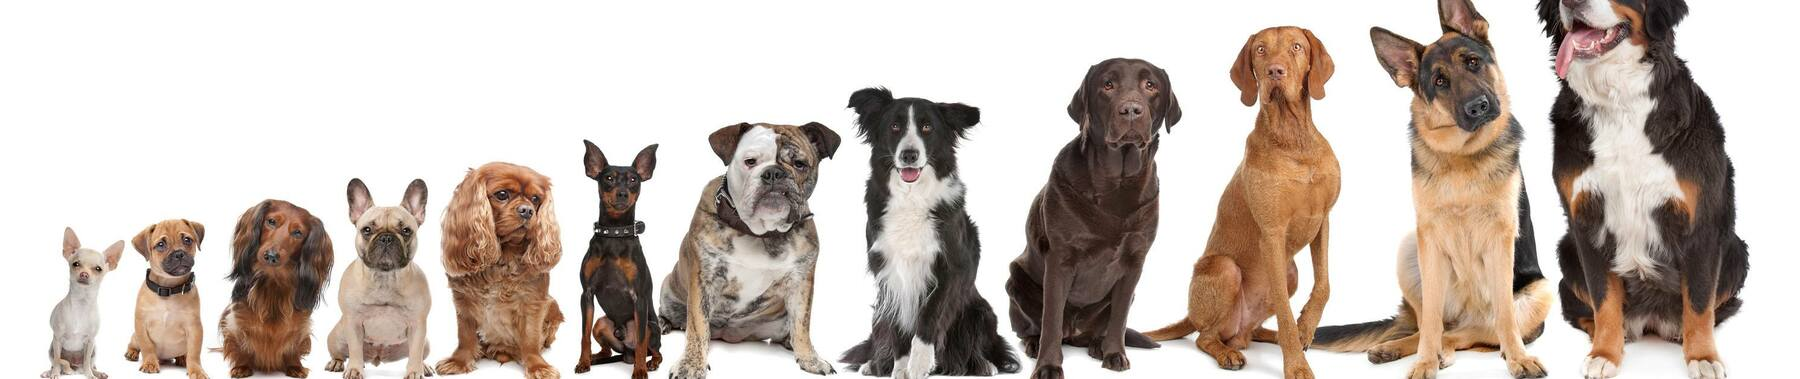

# Import Necessary Libraries

In [42]:
import os
import imghdr
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow  import keras
from sklearn.utils.class_weight import compute_class_weight
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report
from google.colab import drive

# Downloading the Dataset

In [3]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
microsoft-catsvsdogs-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# @title Unzipping the data

!unzip /content/microsoft-catsvsdogs-dataset.zip

Archive:  /content/microsoft-catsvsdogs-dataset.zip
replace MSR-LA - 3467.docx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Defining paths

In [5]:
dir = '/content/PetImages'

In [6]:
cat_dir = '/content/PetImages/Cat'
dog_dir = '/content/PetImages/Dog'

# Understanding the data

In [7]:
cat_files = os.listdir('/content/PetImages/Cat')
dog_files = os.listdir('/content/PetImages/Dog')

print(f"Cats picture count: {len(cat_files)}\nDogs picture count: {len(dog_files)} ")

Cats picture count: 12385
Dogs picture count: 12353 


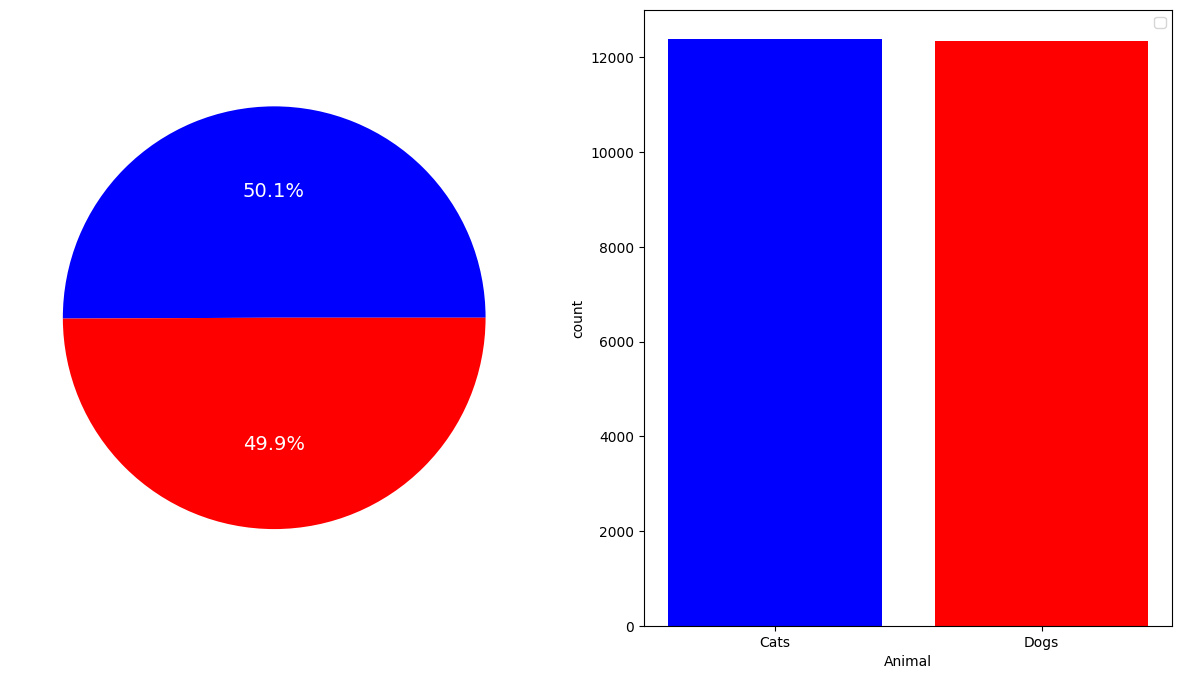

In [8]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.pie([len(cat_files), len(dog_files)], labels=['Cats', 'Dogs'], colors = ['blue', 'red'], autopct='%1.1f%%', textprops={'fontsize': 14, 'color': 'white'})
plt.subplot(1, 2, 2)
plt.bar(['Cats', 'Dogs'], [len(cat_files), len(dog_files)], color = ['blue', 'red'])
plt.xlabel('Animal')
plt.ylabel('count')

plt.legend()
plt.show()

# Data Cleaning and Proccessing

In [9]:
# label dictionary
dict_labels={'Cat':0,'Dog':1}

In [10]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/PetImages'

# Walk through all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
    for file in files:
        # Construct the path to the current file
        file_path = os.path.join(root, file)

        try:
            # Check the file type of the current file
            file_type = imghdr.what(file_path)

            # If the file extension is not in the allowed list, remove it
            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                # Proceed to process the image if needed, for example, reading it with OpenCV
                img = cv2.imread(file_path)

        except Exception as e:
            # Print out the issue and the path of the problematic file
            print(f'Issue with file {file_path}. Error: {e}')
            # Optionally, remove files that cause exceptions
            os.remove(file_path)


In [11]:
cat_files = os.listdir('/content/PetImages/Cat')
dog_files = os.listdir('/content/PetImages/Dog')

print(f"Cats picture count: {len(cat_files)}\nDogs picture count: {len(dog_files)} ")

Cats picture count: 12385
Dogs picture count: 12353 


In [12]:
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=40,
    validation_split=0.2
    )

In [13]:
# Training generator
train_generator = datagen.flow_from_directory(
    '/content/PetImages',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',

    subset='training'
)

# Validation generator
validation_generator = datagen.flow_from_directory(
    '/content/PetImages',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 19791 images belonging to 2 classes.
Found 4947 images belonging to 2 classes.


# VGG16 Architecture - Transfer Learning

In [14]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

In [15]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [16]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [19]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
path = '/content/catVsdogs.keras'

model_checkpoint = ModelCheckpoint(
filepath=path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
)

model_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True,
    start_from_epoch=1
)

# Training the Model

In [21]:
result = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[model_checkpoint, model_early_stopping]
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


539/619 ━━━━━━━━━━━━━━━━━━━━ 20s 254ms/step - accuracy: 0.7814 - loss: 0.4490

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.7890 - loss: 0.4364
Epoch 1: val_loss improved from inf to 0.26108, saving model to /content/catVsdogs.keras
619/619 ━━━━━━━━━━━━━━━━━━━━ 213s 324ms/step - accuracy: 0.7891 - loss: 0.4363 - val_accuracy: 0.8884 - val_loss: 0.2611
Epoch 2/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8936 - loss: 0.2457
Epoch 2: val_loss improved from 0.26108 to 0.24946, saving model to /content/catVsdogs.keras
619/619 ━━━━━━━━━━━━━━━━━━━━ 236s 297ms/step - accuracy: 0.8936 - loss: 0.2456 - val_accuracy: 0.8866 - val_loss: 0.2495
Epoch 3/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9129 - loss: 0.2101
Epoch 3: val_loss improved from 0.24946 to 0.20927, saving model to /content/catVsdogs.keras
619/619 ━━━━━━━━━━━━━━━━━━━━ 202s 298ms/step - accuracy: 0.9129 - loss: 0.2101 - val_accuracy: 0.9139 - val_loss: 0.2093
Epoch 4/50
619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9185 - loss: 0.1935
Epoch 4: val_loss did

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,989,444 (99.14 MB)

 Trainable params: 9,177,089 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 9,177,091 (35.01 MB)

# Accuracy and Loss Graph

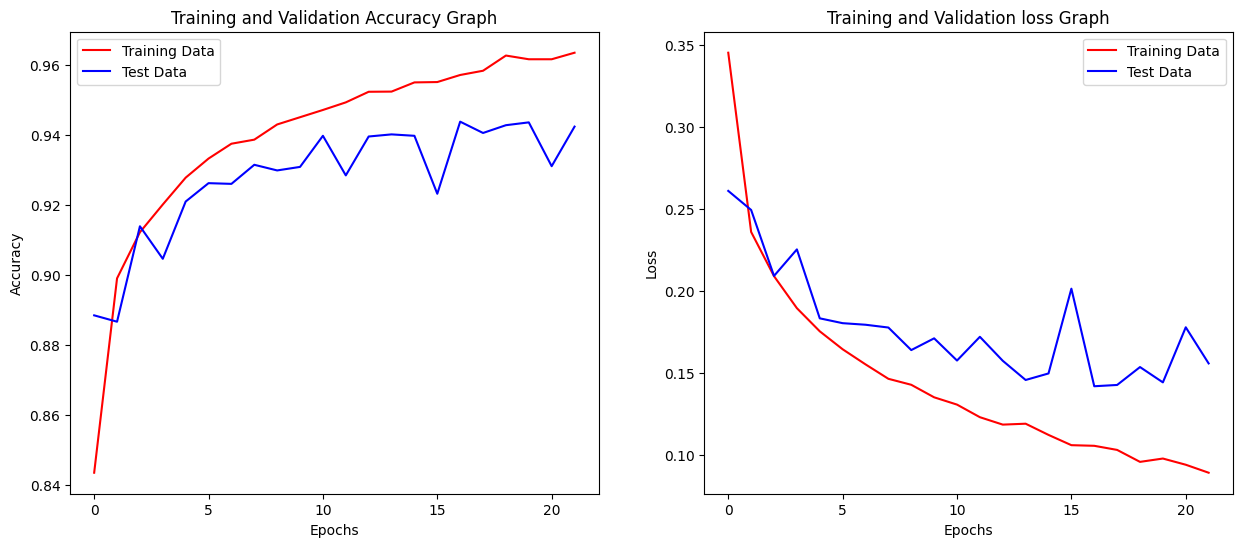

In [23]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(result.history['accuracy'], color='r', label="Training Data")
plt.plot(result.history['val_accuracy'], color='b', label="Test Data")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy Graph")

plt.subplot(1,2,2)
plt.plot(result.history['loss'], color='r', label="Training Data")
plt.plot(result.history['val_loss'], color='b', label="Test Data")
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation loss Graph")

plt.show()

# Evaluating the Model

In [24]:
predictions = model.predict(validation_generator)

155/155 ━━━━━━━━━━━━━━━━━━━━ 34s 214ms/step


In [25]:
# Extract predicted labels from the prediction
prediction_list = []

for pred in predictions:
    prediction_list.append(int(np.round(pred[0])))

In [26]:
# Get true labels
true_labels = validation_generator.classes

In [27]:
# Generate the classification report
report = classification_report(true_labels, prediction_list, target_names=list(validation_generator.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

         Cat       0.49      0.50      0.50      2477
         Dog       0.49      0.48      0.49      2470

    accuracy                           0.49      4947
   macro avg       0.49      0.49      0.49      4947
weighted avg       0.49      0.49      0.49      4947



# Testing on individual Images

In [28]:
def predict_animal(img_path):
    img = cv2.imread(img_path)
    img_resize = cv2.resize(img, (150, 150))
    img_resize = np.array(img_resize, dtype=np.float32)
    img_resize /= 255.0
    img_input = img_resize.reshape(1, 150, 150, 3)
    prediction = model.predict(img_input)

    if prediction[0][0] > 0.5:
        title = "It's a dog."
    else:
        title = "It's a cat."

    plt.figure(figsize=(3, 2))
    plt.axis("off")
    plt.title(title)
    plt.imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


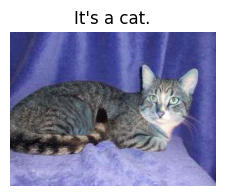

In [29]:
predict_animal("/content/PetImages/Cat/10004.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


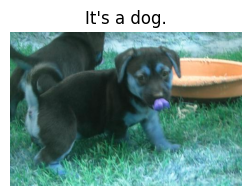

In [30]:
predict_animal("/content/PetImages/Dog/3204.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


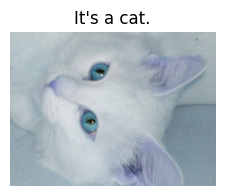

In [31]:
predict_animal("/content/PetImages/Cat/9876.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


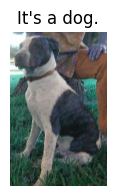

In [32]:
predict_animal("/content/PetImages/Dog/7853.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


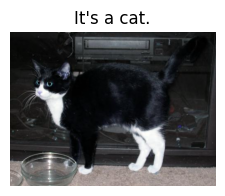

In [33]:
predict_animal("/content/PetImages/Cat/321.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


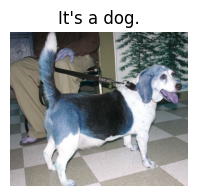

In [34]:
predict_animal("/content/PetImages/Dog/9898.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


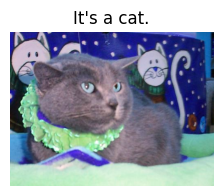

In [35]:
predict_animal("/content/PetImages/Cat/8989.jpg")

# Uploading the model on drive

In [36]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:

# Define the path where you want to save the model in your Google Drive
model_save_path = '/content/drive/MyDrive/Image_classification/catVsdogs.keras'

# Save your trained model to the specified path
model.save(model_save_path)

In [39]:
# Unmount Google Drive
drive.flush_and_unmount()